In [125]:
import json
import requests
import pandas as pd
import plotly.express as px
from dash import html, dcc
from dash.dependencies import Input, Output
from jupyter_dash import JupyterDash
import numpy as np

In [7]:
base_coord = (52.5162829, 13.3777240)

Retrieve all German geolocated Wikipedia entries 1,000m around Brandenburg Gate, save as df with 1 page per row.

In [8]:
url = "https://de.wikipedia.org/w/api.php"

params = {
    "action": "query",
    "format": "json",
    "list": "geosearch",
    "formatversion": "2",
    "gscoord": "|".join(map(str, base_coord)),
    "gsradius": "1000",
    "gslimit": "500"
}

response = requests.get(url, params = params)
print(response)
response_dict = json.loads(response.text)
n_results = len( response_dict["query"]["geosearch"] )
print(f"Found {n_results} articles in this area.")

pages_df = pd.json_normalize(response_dict["query"]["geosearch"])
pages_df.set_index("pageid", inplace=True)
pages_df.head()

<Response [200]>
Found 360 articles in this area.


,ns,title,lat,lon,dist,primary
pageid,,,,,,
11830550,0,Berliner Siegesparade 1871,52.516389,13.377778,12.3,True
11349,0,Brandenburger Tor,52.516389,13.377778,12.3,True
10900841,0,Berliner Siegesparade 1945,52.516389,13.377778,12.3,True
613667,0,Radweg Berlin–Kopenhagen,52.516389,13.377778,12.3,True
1710722,0,Platz des 18. März,52.516250,13.377286,29.9,True


Extract page IDs and forward them to a query of pageviews.

In [9]:
params = {
    "action": "query",
    "format": "json",
    "prop": "pageviews",
    "pvipdays": "30",
    "pageids": "", # will add pageids next
    "formatversion": "2"
}

# prepare page ids as a checklist to work off:
page_ids = list(pages_df.index)

# returns a df [pageid | views] with each row a page with id from params:
def query_views_to_df(params):
    response = requests.get(url, params = params)
    response_dict = json.loads(response.text)
    response_df = pd.json_normalize(response_dict["query"]["pages"])
    views = response_df.iloc[:,0:3]
    views["views"] = response_df.filter(regex="pageviews").sum(axis=1)
    views = views[["pageid", "views"]]
    views.set_index("pageid", inplace=True)
    return(views)

# start with the first chunk:
page_id_string = "|".join(map(str, page_ids[0:50]))

# subtract these up to 50 ids from our check list:
if len(page_ids) >= 50:
    page_ids = page_ids[50:len(page_ids)]
else:
    page_ids = None

# prepare params and query:
params["pageids"] = page_id_string
page_views_df = query_views_to_df(params)

# now, given the df structure in page_views_df, proceed to end of page id list:
while page_ids:
    if len(page_ids) >= 50:
        params["pageids"] = "|".join(map(str, page_ids[0:50]))
        page_ids = page_ids[50:len(page_ids)]
    else:
        params["pageids"] = "|".join(map(str, page_ids))
        page_ids = None
    chunk_df = query_views_to_df(params)
    page_views_df = pd.concat( [page_views_df, chunk_df], axis=0)

In [129]:
df = pages_df.join(page_views_df)
df.sort_values("views", ascending=False, inplace=True)
max_views = max(df.views)

In [190]:
help(np.histogram)

Help on function histogram in module numpy:

histogram(a, bins=10, range=None, normed=None, weights=None, density=None)
    Compute the histogram of a dataset.
    
    Parameters
    ----------
    a : array_like
        Input data. The histogram is computed over the flattened array.
    bins : int or sequence of scalars or str, optional
        If `bins` is an int, it defines the number of equal-width
        bins in the given range (10, by default). If `bins` is a
        sequence, it defines a monotonically increasing array of bin edges,
        including the rightmost edge, allowing for non-uniform bin widths.
    
        .. versionadded:: 1.11.0
    
        If `bins` is a string, it defines the method used to calculate the
        optimal bin width, as defined by `histogram_bin_edges`.
    
    range : (float, float), optional
        The lower and upper range of the bins.  If not provided, range
        is simply ``(a.min(), a.max())``.  Values outside the range are
        ig

[ 2  0  0  3  6  7  7 19 15 20 18 25 31 24 32 17 27 24 17 15 15  6 14  4
  6  1  1  2  1  1]
[ 1.09861229  1.41028333  1.72195438  2.03362542  2.34529646  2.65696751
  2.96863855  3.28030959  3.59198064  3.90365168  4.21532272  4.52699377
  4.83866481  5.15033585  5.4620069   5.77367794  6.08534898  6.39702003
  6.70869107  7.02036211  7.33203315  7.6437042   7.95537524  8.26704628
  8.57871733  8.89038837  9.20205941  9.51373046  9.8254015  10.13707254
 10.44874359]


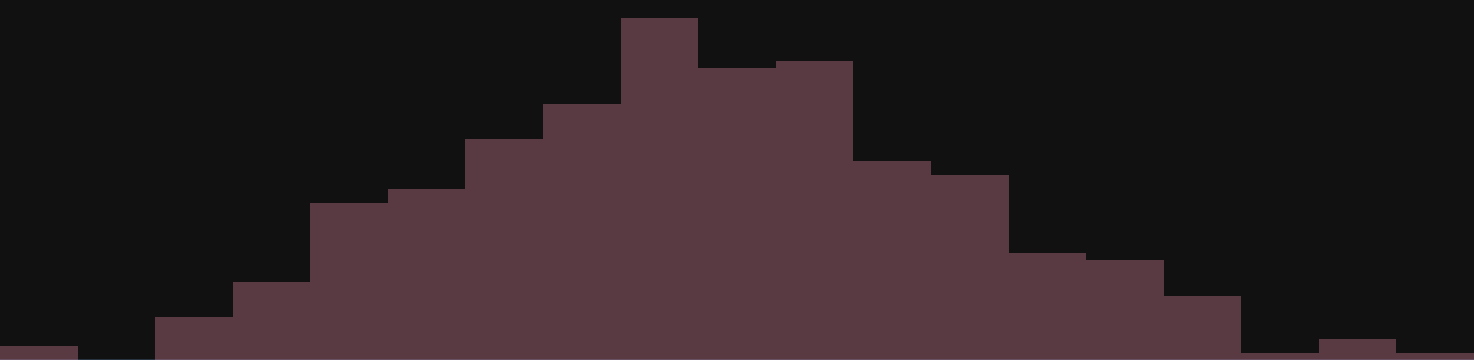

In [193]:
# try hist
counts, bins = np.histogram(df.log_views, bins = 30)
print(counts)
print(bins)

df["log_views"] = np.log(df.views)



Plot

In [214]:
app = JupyterDash(__name__)

app.layout = html.Div([
    
    # Map background
    html.Div(
        style = {
            "width": "99%",
            "height": "300px"
        },
        children = [
            dcc.Graph(id="map")
        ]),
    
    # sidebar right
    html.Div(
        id = "sidebar",
        style = {
            "position": "fixed",
            "width": "250px",
            "right": "0px",
            "top": "50px",
            "marginRight": "30px",
        },
        children = [            
            html.Div(
                id = "hist-plot",
                style = {
                    "backgroundColor": "rgba(255,255,255, .3)",
                    "padding": "15px 15px 15px 15px",
                    "borderRadius": "5px",
                    "marginTop": "15px"
                },
                children = [
                    dcc.Graph(id = "histogram"),
                    dcc.RangeSlider(
                            1,
                            360,
                            step=10,
                            value=[1,360],
                            marks={},
                            id = "slider")
                ]
            )
            
            
        ])
    
    #html.Div(
    #    style = {
    #        "position": "fixed",
    #        "width": "250px",
    #        "backgroundColor": "rgba(255,255,255, .3)",
    #        "right": "0px",
    #        
    #)
])

@app.callback(
    Output(component_id="map", component_property="figure"),
    Output(component_id="histogram", component_property="figure"),
    [Input(component_id='slider', component_property='value')]
)

def update_output_div(input_value):
    
    
    # map rendering:
    df_plot = df.iloc[0:360]
    fig = px.scatter_mapbox(df_plot,
                            lat = "lat",
                            lon = "lon",
                            color = "views",
                            color_continuous_scale = "Pinkyl_r",
                            size = "views",
                            hover_name = "title",
                            hover_data = ["views"],
                            mapbox_style="carto-darkmatter",
                            zoom = 14)
    fig.update_layout(margin = dict(t=0, r=0, b=0, l=0),
                      height = 800,
                      coloraxis_showscale=False)
    fig["data"][0]["hovertemplate"] = "<b>%{hovertext}</b><br><br>Aufrufe in den letzten 30 Tagen: %{marker.color}<extra></extra>"
    
    # histogram:
    hist = px.histogram(
        df,
        x = "log_views",
        nbins = 30,
        template = "plotly_dark"
    )
    
    hist.update_layout(
        xaxis = dict(
            title = None,
            tickvals = []
        ),
        yaxis_showgrid = False,
        yaxis_title = None,
        yaxis_tickvals = [],
        height = 150,
        margin = dict(t=0, r=0, b=0, l=0),
        plot_bgcolor = "rgba(0,0,0,0)",
        paper_bgcolor = "rgba(0,0,0,0)"
    )

    hist.update_traces(marker_color = "rgba(255,150,180, .7)",
                       hovertemplate = "Artikel exp(%{x}) Mal besucht<br>%{y} Orte<extra></extra>"
                 )
        
    return(fig, hist)


if __name__ == '__main__':
    app.run_server(mode = "inline")
